# Convex analysis of mixtures of non-negative sources (CAMNS)
This notebook presents implementation of method of blind source separation of non-negative values based on [the following paper](https://www.researchgate.net/publication/251134144_A_Convex_Analysis_Framework_for_Blind_Separation_of_NonNegative_Sources).

## Non-negative blind source separation (nBSS)
Consider a matrix $S$ depicting some signal values (each vector in matrix represents a different value), an mixture matrix $A$ and a mixed signal $X$ of form:
$$
X = AS
$$
The problem of obtaining matrix $S$ in the abscence of matrix $A$ (of dimensions $M \times N$ based purely on matrix $X$. Under certain assumptions, namely:

1. Componentwise non-negativity of vectors composing $S$
2. Unit row sum for mixing matrix, namely $\forall i \in \{1, \ldots, M\} \sum\limits_{j=1}^{N} A_{ij} = 1$
3. $M \geqslant N$ and $A$ is of full column rank
4. Each source signal is local dominant, i. e. for each $i$ exists $l_i$ such that $s_i[l_i] > 0$ and $s_j[l_i] = 0$ for $j \neq i$

such problem is called **non-negative Blind Source Separation**.

This notebook demonstrates a solution where such problem is reduced to a problem of Linear Programming. Linear Programming problems are solved using CVXPY embedded DSL for convex optimization problems.

In [1]:
from camns import CAMNS_LP
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

np.random.seed(42)  # For repreducability

%load_ext autoreload
%autoreload 2
%matplotlib inline

First of all, we shall define some convenience functions.

In [2]:
def prepare_img(im):
    im = np.array(im, dtype=np.float64)

    if len(im.shape) > 2:
        im = im[..., 0]  # We will leave only one channel as example
        
    np.divide(im, 255.0, out=im)  # Scale channel
    return im.flatten()  # Turn matrix into vector and return

def load_images(paths):
    imgs = list()
    
    for path in paths:
        im = Image.open(path)
        imgs.append(prepare_img(im))
        
    return imgs

def show_images(imgs, side=128, nrows=None, ncols=None):
    if nrows is None or ncols is None:
        nrows = 2
        ncols = len(imgs) // nrows
        
    fig, axs_packed = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = list()
    
    for axs_pack in axs_packed:
        axs += list(axs_pack)
    
    for ax, img in zip(axs, imgs):
        ax.imshow(img.reshape((side, side)), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

Let's generate paths and load some images

In [3]:
paths = map(lambda i: "wolves/wolf{}.png".format(i), range(1, 5))
images = load_images(paths)

Look at these cuties! (I mean, what could've you expected from me, right?)

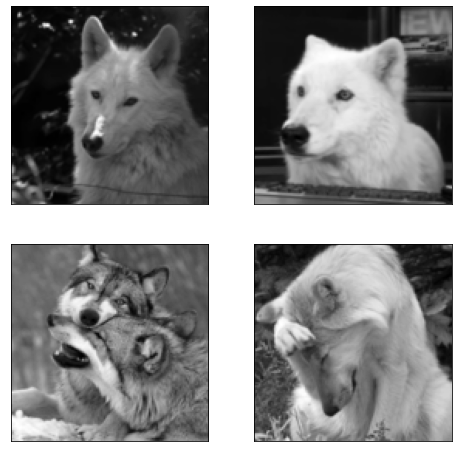

In [4]:
show_images(images, nrows=2, ncols=2)

Now we will generate a random matrix and normalize it to meet the unit row assumption. After that, we will mix our images using this matrix.

In [5]:
N = len(images)  # Number of images
random_matrix = np.random.rand(N, N)
mixing_matrix = random_matrix / np.sum(random_matrix, axis=1, keepdims=True)
mixed = mixing_matrix @ images

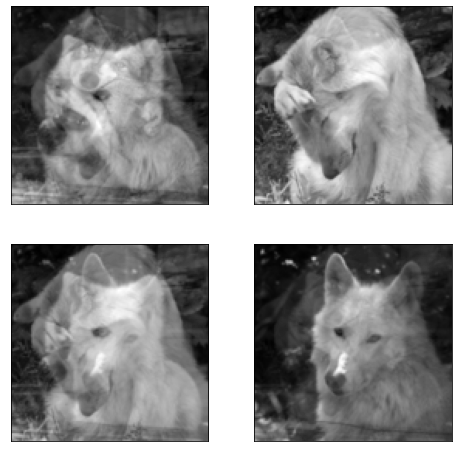

In [6]:
show_images(mixed)

And now it looks like a mess! Luckily, we have a wonderful function I've spent a considerable amount of time writing that will untangle images. Let's run it.

In [7]:
restored = CAMNS_LP(mixed, N)

Epoch 1:
	Launching LP solver 1
	Launching LP solver 2
	LP solvers have finished, checking results
	Retrieved 2/4 sources

Epoch 2:
	Launching LP solver 1
	Launching LP solver 2
	LP solvers have finished, checking results
	Retrieved 4/4 sources



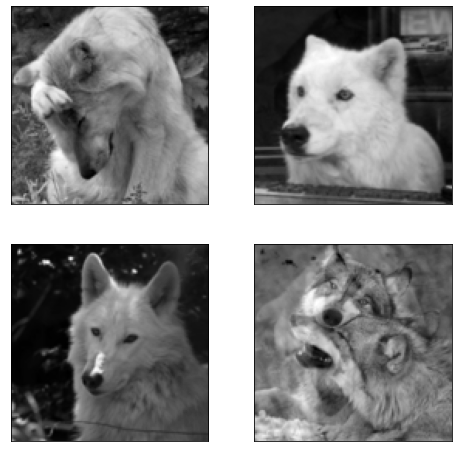

In [8]:
show_images(restored)

Seems to work fine!

*Disclaimer*: Frankly, originally I have wanted to include more pictures of wolves, but it seems that with a lot of pictures the algorithm may experience trouble with their separation, particularly with pictures of wolves (perhaps it just cannot handle the cuteness of them), so I had to settle with four.

Finally, let's run a simple benchmark:

In [9]:
%time separated = CAMNS_LP(mixed, N, verbose = False)

CPU times: user 8.53 s, sys: 15.9 s, total: 24.4 s
Wall time: 8.83 s


# Thank you for your attention!
Here's an incredebly cute wolf

![inceredebly cute wolf](img/wolf.jpg)